# 1-LinearRegression

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.model_selection import train_test_split

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = boston.target
# 数据集划分, 训练集：验证集 = 7:3
x_train, x_val, y_train, y_val = train_test_split(X, Y, 
                                                  test_size=0.3, 
                                                  random_state=20)
linear = linear_model.LinearRegression() # 建立最小二乘法线性模型
linear.fit(x_train, y_train) #拟合模型
print(linear.score(x_train, y_train)) # 返回线性拟合的R方
print(linear.coef_) # 获得各个变量的权重
print(linear.intercept_) # 获得各个变量的偏置项

ModuleNotFoundError: No module named 'pandas'

# 查看权重参数

In [3]:
res_parms = pd.DataFrame([float("%.5f"%i) for i in linear.coef_], index=x_train.columns, columns=['params'])
res_parms.sort_values(by=['params'], inplace=True, ascending=True)
print(res_parms)

,params
NOX,-20.33510
DIS,-1.25565
PTRATIO,-0.85565
LSTAT,-0.45576
CRIM,-0.06193
TAX,-0.01025
B,0.00936
AGE,0.00952
ZN,0.02812
INDUS,0.03668


# 2-logistic regression

In [ ]:
# 此处需要先下载kaggle原始数据（https://www.kaggle.com/c/titanic/data），然后执行下面的预处理工作

In [ ]:
# coding: utf-8
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestRegressor

### Loding data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Concat train + test
alldata = pd.concat([train.ix[:, 'Pclass':'Embarked'], test.ix[:, 'Pclass':'Embarked']]).reset_index(drop=True)

### Cleaning the data
# Fare
alldata['Fare'] = alldata['Fare'].fillna(alldata['Fare'].mean()) # median()

# Embarked
alldata['Embarked'] = alldata['Embarked'].fillna(alldata['Embarked'].mode()[0])

# Age: Fill in missing values with RandomForestClassifier
def set_missing_ages(df):
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y = known_age[:, 0]
    X = known_age[:, 1:]
    rfr = RandomForestRegressor(random_state=10, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    predictedAges = rfr.predict(unknown_age[:, 1::])
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    return df, rfr
alldata, rfr = set_missing_ages(alldata)

### Constructing features
alldata['CabinHead'] = alldata['Cabin'].str[0]
alldata['CabinHead'] = alldata['CabinHead'].fillna('None')
alldata['CabinAlpha'] = (alldata['CabinHead'].isin(['B','D','E'])) * 1
alldata['NullCabin'] = (alldata['Cabin'].notnull()==True) * 1
alldata['NullCabin'] = alldata['NullCabin'].fillna(0)
alldata['NoSibSp'] = (alldata['SibSp']<=0) * 1
alldata['NoParch'] = (alldata['Parch']<=0) * 1
alldata['Family'] = alldata['SibSp'] + alldata['Parch'] + 1 
alldata['isAlone'] = (alldata['Family']==1) * 1

# Constructing a real fare for everyone from Ticket
Ticket = pd.DataFrame(alldata['Ticket'].value_counts())
Ticket.columns = ['PN']
Ticket.head()
alldata1 = pd.merge(alldata, Ticket, left_on = 'Ticket',right_index = True)
alldata['realFare'] = alldata['Fare']/alldata1['PN']

# Constructing each person's rank from Name
alldata['Title'] = alldata['Name'].str.split(", |\.", expand=True)[1]
alldata.ix[alldata['Title'].isin(['Ms','Mlle']),'Title' ] = 'Miss'
alldata.ix[alldata['Title'].isin(['Mme']),'Title' ] ='Mrs'
stat_min = 10 
title_names = (alldata['Title'].value_counts() < stat_min)
alldata['Title'] = alldata['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

# Constructing a ismother label
alldata['ismother'] = ((alldata['Sex']=='female') & (alldata['Parch'] > 0) \
                    & (alldata['Age']>=16) & (alldata['Title']=='Mrs')) *1

alldata = alldata.drop(['Name','SibSp', 'Parch','Ticket', 'Fare','Cabin', 'CabinHead'], axis=1)

### Dividing the preprocessed files into trainSet and testSet
train_ = pd.concat([alldata.iloc[:train.shape[0],:], train[['Survived']]], axis=1)
test_ = alldata.iloc[train.shape[0]:,:]

### Getting dummies for category features
objList = ['Pclass','Sex','Embarked','Title']
temp_obj = pd.concat([pd.get_dummies(train_[i], prefix = i) for i in objList], axis=1)
temp_num = train_[['NoSibSp', 'NoParch', 'NullCabin', 'CabinAlpha', 'Family', 'isAlone','ismother','Age','realFare','Survived']]
trainSet = pd.concat([temp_obj,temp_num], axis = 1)

temp_obj = pd.concat([pd.get_dummies(test_[i], prefix = i) for i in objList], axis=1)
temp_num = test_[['NoSibSp', 'NoParch', 'NullCabin', 'CabinAlpha', 'Family', 'isAlone','ismother','Age','realFare']]
testSet = pd.concat([temp_obj,temp_num], axis = 1)

### Scaling data
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(trainSet[['Age']])
trainSet['Age'] = scaler.fit_transform(trainSet[['Age']], age_scale_param)
testSet['Age'] = scaler.fit_transform(testSet[['Age']], age_scale_param)

fare_scale_param = scaler.fit(trainSet[['realFare']])
trainSet['realFare'] = scaler.fit_transform(trainSet[['realFare']], fare_scale_param)
testSet['realFare'] = scaler.fit_transform(testSet[['realFare']], age_scale_param)

trainSet.columns = [i.lower() for i in trainSet.columns]
testSet.columns = [i.lower() for i in testSet.columns]

trainSet.to_csv('train_dp.csv', index=False)
testSet.to_csv('test_dp.csv', index=False)

In [5]:
import pandas
from sklearn import linear_model
# 数据加载
data = pd.read_csv('train_dp.csv')
Y = data['survived']
X = data.drop(columns=['survived'])

# 数据集划分
x_train, x_val, y_train, y_val = train_test_split(X, Y, 
                                                  test_size=0.3, 
                                                  random_state=20)

lr = linear_model.LogisticRegression(penalty='l2') # 建立最小二乘法线性模型
lr.fit(x_train, y_train) #拟合模型
print(lr.score(x_train, y_train)) # 返回线性拟合的R方
print(lr.coef_)# 获得各个变量的权重
print(lr.intercept_) # 获得各个变量的偏置项

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([1.37332049])

# 查看权重参数

In [7]:
res_parms = pd.DataFrame([float("%.5f"%i) for i in lr.coef_[0]], index=x_train.columns, columns=['params'])
res_parms.sort_values(by=['params'], inplace=True, ascending=True)
res_parms

,params
title_mr,-1.97366
title_misc,-1.25112
pclass_3,-0.88747
age,-0.53476
sex_male,-0.48013
family,-0.26502
embarked_s,-0.25008
isalone,-0.07772
nosibsp,-0.01569
title_miss,0.09623


# 3-decision tree

In [48]:
import pandas as pd
from sklearn import tree

# 数据加载
data = pd.read_csv('train_dp.csv')
Y = data['survived']
X = data.drop(columns=['survived'])

# 数据集划分
x_train, x_val, y_train, y_val = train_test_split(X, Y, 
                                                  test_size=0.3, 
                                                  random_state=20)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train, y_train) # 模型训练

In [49]:
y_pred = clf.predict(x_val) #模型预测
from sklearn.metrics import precision_score, recall_score, accuracy_score
precision_score(y_val, y_pred), recall_score(y_val, y_pred), accuracy_score(y_val, y_pred)

(0.7524752475247525, 0.7755102040816326, 0.8246268656716418)

In [ ]:
# 树模型可视化

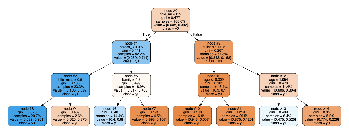

decision tree end


In [50]:
import matplotlib.image as mpimg
import os
import pydotplus
from IPython.core.display import Image
from sklearn.externals.six import StringIO
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=x_train.columns,
                                 class_names=True, filled=True, rounded=True, proportion=True,
                                 special_characters=True, node_ids=True, )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('rules_of_tree.png')
show_pic = 1
if show_pic == True:
    lena = mpimg.imread('rules_of_tree.png')
    plt.imshow(lena)  # 显示图片
    plt.axis('off')  # 不显示坐标轴
    plt.savefig('a.png')
    plt.show()
    print('decision tree end')

# 4-knn

In [72]:
import pandas as pd
from sklearn import neighbors
# 数据加载
data = pd.read_csv('train_dp.csv')
Y = data['survived']
X = data.drop(columns=['survived'])

# 数据集划分
x_train, x_val, y_train, y_val = train_test_split(X, Y, 
                                                  test_size=0.3, 
                                                  random_state=20)
n_neighbors = 15
knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

In [ ]:
# 查看不同K值对评估结果的影响

In [98]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
dic = {}
k_list = np.arange(5, 50, 10)
for k in k_list:
    knn = neighbors.KNeighborsClassifier(k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    dic["k="+str(k)] = [ recall_score(y_val, y_pred), precision_score(y_val, y_pred), accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)]

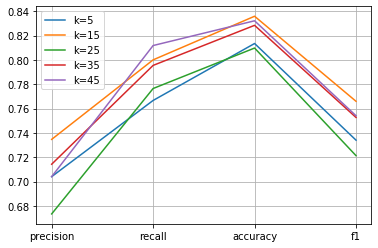

In [121]:
df = pd.DataFrame(dic, index=['precision', 'recall', 'accuracy','f1'])
plt.plot(df)
plt.legend(labels = df.columns)
plt.grid(axis='both')


# 5-贝叶斯

In [171]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB

# 数据加载
data = pd.read_csv('train_dp.csv')
Y = data['survived']
X = data.drop(columns=['survived'])

# 数据集划分
x_train, x_val, y_train, y_val = train_test_split(X, Y, 
                                                  test_size=0.3, 
                                                  random_state=20)
n_neighbors = 15
bayes = GaussianNB(var_smoothing=0)
bayes.fit(x_train, y_train)
print(bayes.theta_) # 获得各个属性属于该类的均值
print(bayes.sigma_) # 获得各个属性属于该类的方差

[[ 0.17941953  0.6701847   0.85224274  0.07124011  0.79155673  0.02638522
   0.10290237  0.7994723   0.04485488  0.7414248   0.81530343  0.13192612
   0.05804749  1.84432718  0.6939314   0.02638522  0.09875492 -0.22876048]
 [ 0.25409836  0.33196721  0.31557377  0.0942623   0.64344262  0.02459016
   0.37704918  0.23360656  0.29508197  0.63114754  0.69672131  0.41393443
   0.26639344  1.93032787  0.49180328  0.10655738 -0.03488015  0.38944656]]
[[0.14722816 0.22103717 0.12592505 0.06616495 0.16499467 0.02568904
  0.09231348 0.16031634 0.04284292 0.19171406 0.15058375 0.11452162
  0.05467798 3.32405093 0.21239061 0.02568904 0.95118755 0.51788232]
 [0.18953238 0.22176498 0.21598697 0.08537691 0.22942421 0.02398549
  0.2348831  0.17903453 0.2080086  0.23280032 0.21130073 0.24259272
  0.19542798 1.49924415 0.24993281 0.0952029  1.12896508 1.56259875]]


In [172]:
print(bayes.predict_proba(x_val))

array([[1.85165933e-04, 9.99814834e-01],
       [9.99374454e-01, 6.25546130e-04],
       [9.99251370e-01, 7.48630081e-04],
       [9.99945180e-01, 5.48201568e-05],
       [3.19521187e-02, 9.68047881e-01],
       [4.04115087e-01, 5.95884913e-01],
       [9.99826307e-01, 1.73693284e-04],
       [9.99954206e-01, 4.57938837e-05],
       [1.30311079e-05, 9.99986969e-01],
       [9.99952960e-01, 4.70403759e-05],
       [7.80227324e-10, 9.99999999e-01],
       [9.99046537e-01, 9.53462740e-04],
       [5.03847218e-17, 1.00000000e+00],
       [9.99946999e-01, 5.30008496e-05],
       [3.48849176e-12, 1.00000000e+00],
       [9.99745468e-01, 2.54531893e-04],
       [9.99344549e-01, 6.55450589e-04],
       [8.21164303e-06, 9.99991788e-01],
       [8.36189862e-12, 1.00000000e+00],
       [3.50718963e-02, 9.64928104e-01],
       [2.40286585e-03, 9.97597134e-01],
       [9.99419687e-01, 5.80312643e-04],
       [7.26333390e-12, 1.00000000e+00],
       [9.99946402e-01, 5.35984509e-05],
       [6.508359

In [136]:
print(bayes.predict(x_val))

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0])